# Test Delineate-Anything avec YOLO

Ce notebook teste le modèle **Delineate-Anything** avec l'interface YOLO sur nos images TCI Sentinel-2.

## Objectif
- Charger le modèle pré-entraîné `MykolaL/DelineateAnything`
- Tester sur les fichiers TCI.tif téléchargés
- Visualiser les limites de champs détectées

In [15]:
# Installation des dépendances
!pip install ultralytics rasterio shapely numpy opencv-python pillow tqdm

In [16]:
import os
import math
import json
import numpy as np
import rasterio
from rasterio.transform import rowcol
from rasterio.transform import Affine
import cv2
from shapely.geometry import Polygon, mapping
from ultralytics import YOLO
from pathlib import Path

In [ ]:
!wget https://huggingface.co/MykolaL/DelineateAnything/blob/main/DelineateAnything.pt

In [6]:
from ultralytics import YOLO
import warnings
warnings.filterwarnings('ignore')

print("🛰️ Chargement du modèle Delineate-Anything depuis le fichier .pt...")

# Charger le modèle Delineate-Anything à partir du fichier .pt
model = YOLO("DelineateAnything.pt")

print("✅ Modèle chargé avec succès!")

🛰️ Chargement du modèle Delineate-Anything depuis le fichier .pt...
✅ Modèle chargé avec succès!


In [7]:
import requests
from tqdm import tqdm

def download_tci_image(url, filename):
    """Télécharge une image TCI depuis l'URL"""
    if Path(filename).exists():
        print(f"✅ {filename} déjà présent")
        return filename

    print(f"⬇️  Téléchargement de {filename}...")

    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))

    with open(filename, 'wb') as f, tqdm(
        desc=f"Téléchargement {filename}",
        total=total_size,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))

    print(f"✅ {filename} téléchargé avec succès!")
    return filename

# URLs des images TCI Sentinel-2
tci_urls = {
    "TCI_EastAfrica_20200701.tif": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/36/Q/WD/2020/7/S2A_36QWD_20200701_0_L2A/TCI.tif",
    "TCI_Asia_20230815.tif": "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/54/T/WN/2023/8/S2A_54TWN_20230815_0_L2A/TCI.tif"
}

# Télécharger les images TCI
tci_files = []
for filename, url in tci_urls.items():
    try:
        downloaded_file = download_tci_image(url, filename)
        tci_files.append(downloaded_file)
    except Exception as e:
        print(f"❌ Erreur téléchargement {filename}: {e}")

print(f"\n📁 {len(tci_files)} fichiers TCI disponibles pour le test")

⬇️  Téléchargement de TCI_EastAfrica_20200701.tif...


Téléchargement TCI_EastAfrica_20200701.tif: 100%|██████████| 224M/224M [00:15<00:00, 15.2MB/s]


✅ TCI_EastAfrica_20200701.tif téléchargé avec succès!
⬇️  Téléchargement de TCI_Asia_20230815.tif...


Téléchargement TCI_Asia_20230815.tif: 100%|██████████| 215M/215M [00:14<00:00, 15.8MB/s]

✅ TCI_Asia_20230815.tif téléchargé avec succès!

📁 2 fichiers TCI disponibles pour le test


📖 Chargement de TCI_EastAfrica_20200701.tif...
✅ Image chargée: (10980, 10980, 3)
   CRS: EPSG:32636
   Résolution: (10.0, 10.0)
   Bounds: BoundingBox(left=499980.0, bottom=1790220.0, right=609780.0, top=1900020.0)


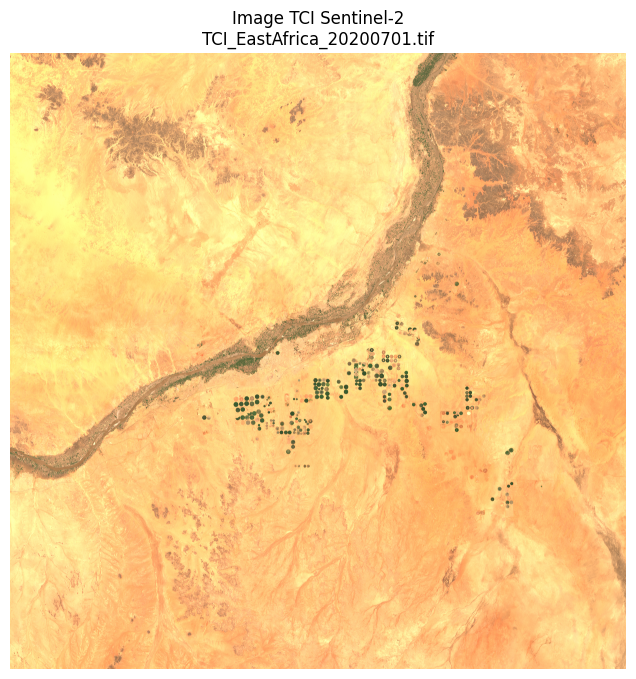

In [18]:
def load_and_display_tci(tci_path):
    """Charge et affiche une image TCI"""
    if not Path(tci_path).exists():
        print(f"❌ Fichier introuvable: {tci_path}")
        return None

    print(f"📖 Chargement de {tci_path}...")

    with rasterio.open(tci_path) as src:
        # Lire les 3 bandes RGB
        rgb_data = src.read([1, 2, 3])  # Bandes R, G, B

        # Transposer pour matplotlib (H, W, C)
        rgb_image = np.transpose(rgb_data, (1, 2, 0))

        # Normaliser si nécessaire
        if rgb_image.dtype == np.uint16:
            rgb_image = (rgb_image / 65535.0 * 255).astype(np.uint8)
        elif rgb_image.max() > 255:
            rgb_image = (rgb_image / rgb_image.max() * 255).astype(np.uint8)

        print(f"✅ Image chargée: {rgb_image.shape}")
        print(f"   CRS: {src.crs}")
        print(f"   Résolution: {src.res}")
        print(f"   Bounds: {src.bounds}")

        # Affichage
        plt.figure(figsize=(12, 8))
        plt.imshow(rgb_image)
        plt.title(f"Image TCI Sentinel-2\n{Path(tci_path).name}")
        plt.axis('off')
        plt.show()

        return rgb_image, src.crs, src.transform

# Charger la première image TCI disponible
if tci_files:
    test_image_path = tci_files[0]
    tile_size = 1024
    conf_thr = 0.5
    iou_thr  = 0.5
    rgb_array, crs, transform = load_and_display_tci(test_image_path)
else:
    print("❌ Aucun fichier TCI disponible pour le test")

In [21]:
# --- lecture du GeoTIFF en RGB uint8 pour servir de fond ---
with rasterio.open(test_image_path) as src:
    rgb = src.read([1, 2, 3]).transpose(1, 2, 0)  # (H,W,3)
    if rgb.dtype == np.uint16:
        rgb = (rgb.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
    elif rgb.max() > 255:
        rgb = (rgb.astype(np.float32) / rgb.max() * 255).astype(np.uint8)
    crs = src.crs
    transform = src.transform
    H, W = src.height, src.width

overlay = rgb.copy()
features = []

print("🚀 Lancement de la détection (tuile par tuile)")
with rasterio.open(test_image_path) as src:
    for y in range(0, src.height, tile_size):
        for x in range(0, src.width, tile_size):
            win = rasterio.windows.Window(
                x, y,
                min(tile_size, src.width - x),
                min(tile_size, src.height - y)
            )
            tile = src.read([1, 2, 3], window=win).transpose(1, 2, 0)
            if tile.dtype == np.uint16:
                tile = (tile.astype(np.float32) / 65535.0 * 255).astype(np.uint8)
            elif tile.max() > 255:
                tile = (tile.astype(np.float32) / tile.max() * 255).astype(np.uint8)

            try:
                preds = model.predict(source=tile, conf=conf_thr, iou=iou_thr, verbose=False)
            except Exception as e:
                print(f"❌ tuile ({x},{y}) — erreur: {e}")
                continue

            for r in preds:
                if getattr(r, "masks", None) is None:
                    continue

                # --- Cas polygones directs ---
                if getattr(r.masks, "xy", None):
                    for poly in r.masks.xy:
                        if poly is None or len(poly) < 3:
                            continue
                        poly = np.array(poly, dtype=np.float32)
                        poly[:, 0] += x
                        poly[:, 1] += y
                        cv2.polylines(overlay, [poly.astype(np.int32)], True, (255, 255, 255), 2)

                        pts_geo = []
                        a, b, c, d, e, f = transform.a, transform.b, transform.c, transform.d, transform.e, transform.f
                        for cx, cy in poly:
                            X = c + a * cx + b * cy
                            Y = f + d * cx + e * cy
                            pts_geo.append((X, Y))
                        if len(pts_geo) >= 3:
                            P = Polygon(pts_geo)
                            if P.is_valid and not P.is_empty and P.area > 0:
                                features.append({"type": "Feature", "properties": {}, "geometry": mapping(P)})

                # --- Cas contours depuis masque binaire ---
                elif getattr(r.masks, "data", None) is not None:
                    mdata = r.masks.data.cpu().numpy()
                    for m in mdata:
                        m = (m > 0.5).astype(np.uint8) * 255
                        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                        for cnt in cnts:
                            if len(cnt) < 3:
                                continue
                            cnt = cnt.reshape(-1, 2).astype(np.float32)
                            cnt[:, 0] += x
                            cnt[:, 1] += y
                            cv2.polylines(overlay, [cnt.astype(np.int32)], True, (255, 255, 255), 2)

                            pts_geo = []
                            a, b, c, d, e, f = transform.a, transform.b, transform.c, transform.d, transform.e, transform.f
                            for cx, cy in cnt:
                                X = c + a * cx + b * cy
                                Y = f + d * cx + e * cy
                                pts_geo.append((X, Y))
                            if len(pts_geo) >= 3:
                                P = Polygon(pts_geo)
                                if P.is_valid and not P.is_empty and P.area > 0:
                                    features.append({"type": "Feature", "properties": {}, "geometry": mapping(P)})

            print(f"✅ tuile ({x},{y}) traitée")

# Sauvegardes
cv2.imwrite("overlay.png", cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
geojson = {
    "type": "FeatureCollection",
    "features": features,
    "crs": {"type": "name", "properties": {"name": str(crs)}}
}
with open("fields.geojson", "w", encoding="utf-8") as f:
    json.dump(geojson, f)

print("🎉 Fini !")
print(" - overlay.png : image avec délimitations")
print(" - fields.geojson : polygones pour dashboard")


🚀 Lancement de la détection (tuile par tuile)
✅ tuile (0,0) traitée
✅ tuile (1024,0) traitée
✅ tuile (2048,0) traitée
✅ tuile (3072,0) traitée
✅ tuile (4096,0) traitée
✅ tuile (5120,0) traitée
✅ tuile (6144,0) traitée
✅ tuile (7168,0) traitée
✅ tuile (8192,0) traitée
✅ tuile (9216,0) traitée
✅ tuile (10240,0) traitée
✅ tuile (0,1024) traitée
✅ tuile (1024,1024) traitée
✅ tuile (2048,1024) traitée
✅ tuile (3072,1024) traitée
✅ tuile (4096,1024) traitée
✅ tuile (5120,1024) traitée
✅ tuile (6144,1024) traitée
✅ tuile (7168,1024) traitée
✅ tuile (8192,1024) traitée
✅ tuile (9216,1024) traitée
✅ tuile (10240,1024) traitée
✅ tuile (0,2048) traitée
✅ tuile (1024,2048) traitée
✅ tuile (2048,2048) traitée
✅ tuile (3072,2048) traitée
✅ tuile (4096,2048) traitée
✅ tuile (5120,2048) traitée
✅ tuile (6144,2048) traitée
✅ tuile (7168,2048) traitée
✅ tuile (8192,2048) traitée
✅ tuile (9216,2048) traitée
✅ tuile (10240,2048) traitée
✅ tuile (0,3072) traitée
✅ tuile (1024,3072) traitée
✅ tuile (2048,30

🖼️ Affichage de l'image d'overlay (overlay.png)...


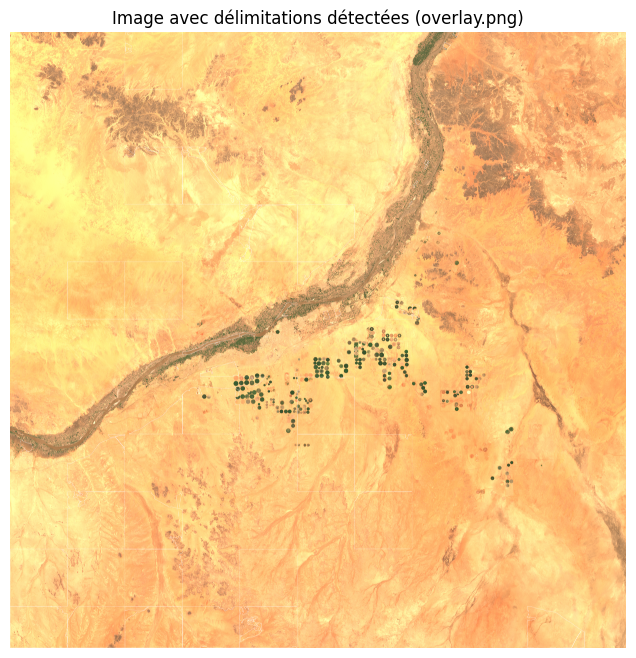

✅ Image affichée avec succès!


In [22]:
from PIL import Image
import matplotlib.pyplot as plt

print("🖼️ Affichage de l'image d'overlay (overlay.png)...")

try:
    # Open the overlay image
    img = Image.open("overlay.png")

    # Display the image using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.title("Image avec délimitations détectées (overlay.png)")
    plt.axis('off')
    plt.show()

    print("✅ Image affichée avec succès!")

except FileNotFoundError:
    print("❌ Erreur : Le fichier overlay.png n'a pas été trouvé.")
    print("Veuillez vous assurer que la détection a été exécutée et que le fichier a été généré.")
except Exception as e:
    print(f"❌ Une erreur est survenue lors de l'affichage de l'image : {e}")

In [11]:
# print("🚀 Lancement de la détection de parcelles agricoles...")
# print("=" * 60)

# # Prédiction avec Delineate-Anything en utilisant le tuilage (tiling)
# if tci_files and Path(test_image_path).exists():

#     print(f"🛰️  Image d'entrée: {test_image_path}")
#     print(f"📏 Taille de l'image: {rgb_array.shape}")

#     # Define tile size (adjust as needed)
#     tile_size = 1024  # Example tile size

#     results = []

#     with rasterio.open(test_image_path) as src:
#         height = src.height
#         width = src.width

#         # Iterate through tiles
#         for y in range(0, height, tile_size):
#             for x in range(0, width, tile_size):
#                 # Define window for the tile
#                 window = rasterio.windows.Window(x, y, min(tile_size, width - x), min(tile_size, height - y))

#                 # Read data for the tile
#                 tile_data = src.read([1, 2, 3], window=window)
#                 tile_image = np.transpose(tile_data, (1, 2, 0))

#                 # Normalize if necessary (same logic as in load_and_display_tci)
#                 if tile_image.dtype == np.uint16:
#                     tile_image = (tile_image / 65535.0 * 255).astype(np.uint8)
#                 elif tile_image.max() > 255:
#                      tile_image = (tile_image / tile_image.max() * 255).astype(np.uint8)

#                 # Convert tile_image to a format acceptable by model.predict
#                 # This might require saving the tile to a temporary file or converting to a specific format
#                 # For now, we'll attempt to predict directly on the numpy array,
#                 # but this might need adjustment based on the model's expected input.
#                 try:
#                     # Lancer la prédiction sur la tuile
#                     tile_results = model.predict(source=tile_image, save=False, conf=0.5) # save=False to avoid saving many tile results
#                     results.extend(tile_results)
#                     print(f"✅ Prédiction terminée pour la tuile ({x},{y})")
#                 except Exception as e:
#                     print(f"❌ Erreur lors de la prédiction pour la tuile ({x},{y}): {e}")


#     print(f"✅ Prédiction terminée pour toutes les tuiles!")
#     print(f"📊 {len(results)} résultat(s) obtenu(s) au total")

#     # Note: Combining results from tiles (e.g., stitching masks or handling overlapping bounding boxes)
#     # is a complex step that is not implemented in this basic example.
#     # Further processing of the 'results' list would be needed here.

#     # Afficher un exemple de résultat (peut-être le premier ou un agrégé si combiné)
#     if results:
#          # You would need to implement logic here to combine or visualize results from tiles
#          print("\n⚠️  Results from tiles are not combined or fully visualized in this basic example.")
#          print("   Further steps are needed to process and visualize the aggregated results.")
#     else:
#         print("\n⚠️  Aucun résultat de détection obtenu des tuiles.")


# else:
#     print("❌ Aucune image TCI disponible pour le test")

🚀 Lancement de la détection de parcelles agricoles...
🛰️  Image d'entrée: TCI_EastAfrica_20200701.tif
📏 Taille de l'image: (10980, 10980, 3)

0: 512x512 (no detections), 82.2ms
Speed: 23.1ms preprocess, 82.2ms inference, 115.9ms postprocess per image at shape (1, 3, 512, 512)
✅ Prédiction terminée pour la tuile (0,0)

0: 512x512 (no detections), 80.3ms
Speed: 9.2ms preprocess, 80.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)
✅ Prédiction terminée pour la tuile (1024,0)

0: 512x512 1 field, 78.6ms
Speed: 8.3ms preprocess, 78.6ms inference, 259.9ms postprocess per image at shape (1, 3, 512, 512)
✅ Prédiction terminée pour la tuile (2048,0)

0: 512x512 (no detections), 78.6ms
Speed: 9.6ms preprocess, 78.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
✅ Prédiction terminée pour la tuile (3072,0)

0: 512x512 (no detections), 68.8ms
Speed: 9.8ms preprocess, 68.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 512)
✅ Prédiction terminé